# Import libraries

In [53]:
from torchvision import transforms, datasets
import torchvision
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import matplotlib.pyplot as plt

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Choose and download dataset

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import kagglehub

data = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", data)

Path to dataset files: /kaggle/input/cards-image-datasetclassification


# 2. Dataset preproccessing

In [43]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) , (0.5,))
])

In [44]:
train_path = '/kaggle/input/cards-image-datasetclassification/train'
test_path = "/kaggle/input/cards-image-datasetclassification/test"
val_path = '/kaggle/input/cards-image-datasetclassification/valid'

In [45]:
train = ImageFolder(train_path, transform=transform)
test = ImageFolder(test_path, transform=transform)
val = ImageFolder(val_path, transform=transform)
classes = train.classes
classes

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

In [46]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)
val_loader = DataLoader(val, batch_size=32, shuffle=True)
for img, label in train_loader:
    break
img.shape

torch.Size([32, 3, 128, 128])

# 3. Create Neural Network

In [47]:
class Model(nn.Module):
  def __init__(self, output_shape):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1),
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=30, kernel_size=3),
        nn.BatchNorm2d(30),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3),
        nn.BatchNorm2d(60),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels=60, out_channels=100, kernel_size=3),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=3600, out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

In [48]:
torch.manual_seed(42)
model = Model(len(classes)).to(device)

In [49]:
image_batch, label_batch = next(iter(train_loader))
image_batch = image_batch.to(device)
model(image_batch)

tensor([[-0.8565,  0.2473,  0.0395,  ...,  0.2567, -0.4270, -0.1690],
        [-1.5922,  0.9658,  0.4212,  ...,  2.3735, -0.5131,  1.4405],
        [ 0.9280,  0.3304,  2.0421,  ...,  2.1693, -2.8649, -1.2913],
        ...,
        [-0.6523,  0.4379,  1.3453,  ...,  0.4988, -1.2762,  1.0210],
        [-0.4801, -0.8914, -1.0964,  ..., -0.0391, -0.4271, -0.3809],
        [-0.8985,  0.1057,  2.0531,  ...,  1.4649,  0.5224,  0.3925]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [50]:
try :import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary

summary(model , input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 53]                   --
├─Sequential: 1-1                        [1, 10, 63, 63]           --
│    └─Conv2d: 2-1                       [1, 10, 126, 126]         280
│    └─BatchNorm2d: 2-2                  [1, 10, 126, 126]         20
│    └─ReLU: 2-3                         [1, 10, 126, 126]         --
│    └─MaxPool2d: 2-4                    [1, 10, 63, 63]           --
├─Sequential: 1-2                        [1, 30, 30, 30]           --
│    └─Conv2d: 2-5                       [1, 30, 61, 61]           2,730
│    └─BatchNorm2d: 2-6                  [1, 30, 61, 61]           60
│    └─ReLU: 2-7                         [1, 30, 61, 61]           --
│    └─MaxPool2d: 2-8                    [1, 30, 30, 30]           --
├─Sequential: 1-3                        [1, 60, 14, 14]           --
│    └─Conv2d: 2-9                       [1, 60, 28, 28]           16,260
│    └─

# 4. Train Model

In [56]:
optim = optim.Adam(model.parameters(), lr=0.001)
cel = nn.CrossEntropyLoss()
epochs = 15
train_losses = []
val_losses = []

In [52]:
for epoch in range(epochs):
  model.train()
  run_loss = 0
  correct = 0
  total = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optim.zero_grad()
    outputs = model(images)
    loss = cel(outputs, labels)
    loss.backward()
    optim.step()

    run_loss += loss.item() * labels.size(0)

  train_loss = run_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = cel(outputs, labels)
      val_loss += loss.item()


  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  print(f'Epochs: [{epoch + 1} / {epochs}]')
  print(f'Train Loss: {train_loss:.4f}')
  print(f'Validation Loss: {val_loss:.4f}')
  print('-------------------------------------------')

Epochs: [1 / 20]
Train Loss: 2.8686
Validation Loss: 1.7358
-------------------------------------------
Epochs: [2 / 20]
Train Loss: 2.0712
Validation Loss: 1.4640
-------------------------------------------
Epochs: [3 / 20]
Train Loss: 1.7086
Validation Loss: 1.1187
-------------------------------------------
Epochs: [4 / 20]
Train Loss: 1.4479
Validation Loss: 0.9463
-------------------------------------------
Epochs: [5 / 20]
Train Loss: 1.3011
Validation Loss: 0.8443
-------------------------------------------
Epochs: [6 / 20]
Train Loss: 1.1711
Validation Loss: 0.8644
-------------------------------------------
Epochs: [7 / 20]
Train Loss: 1.0445
Validation Loss: 0.7994
-------------------------------------------
Epochs: [8 / 20]
Train Loss: 0.9769
Validation Loss: 0.7418
-------------------------------------------
Epochs: [9 / 20]
Train Loss: 0.9027
Validation Loss: 0.7337
-------------------------------------------
Epochs: [10 / 20]
Train Loss: 0.8326
Validation Loss: 0.7561
---

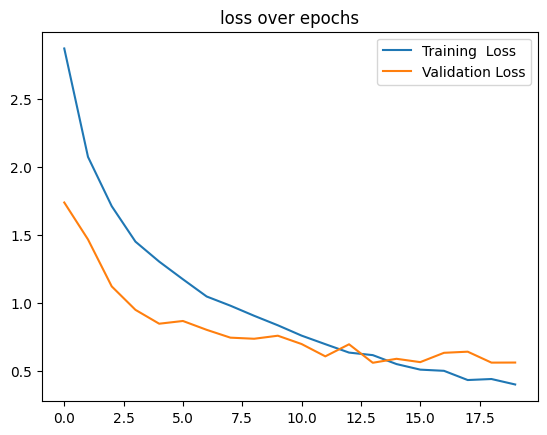

In [55]:
plt.plot(train_losses, label="Training  Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title('loss over epochs')
plt.show()

# 5. Testing Model

In [57]:
def pre_processing(path, transform):
  image = Image.open(path).convert('RGB')
  return image, transform(image).squeeze(0)

In [66]:
def predict(model, img, device):
  model.eval()
  with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    outputs = model(img)
    p = torch.nn.functional.softmax(outputs, dim=1)

  return p.cpu().numpy().flatten()

In [67]:
def visualizer(img, p, class_name):
  fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

  axarr[0].imshow(img)
  axarr[0].axis("off")

  axarr[1].barh(class_name, p)
  axarr[1].set_xlabel("Probability")
  axarr[1].set_title("Class Predictions")
  axarr[1].set_xlim(0, 1)

  plt.tight_layout()
  plt.show()

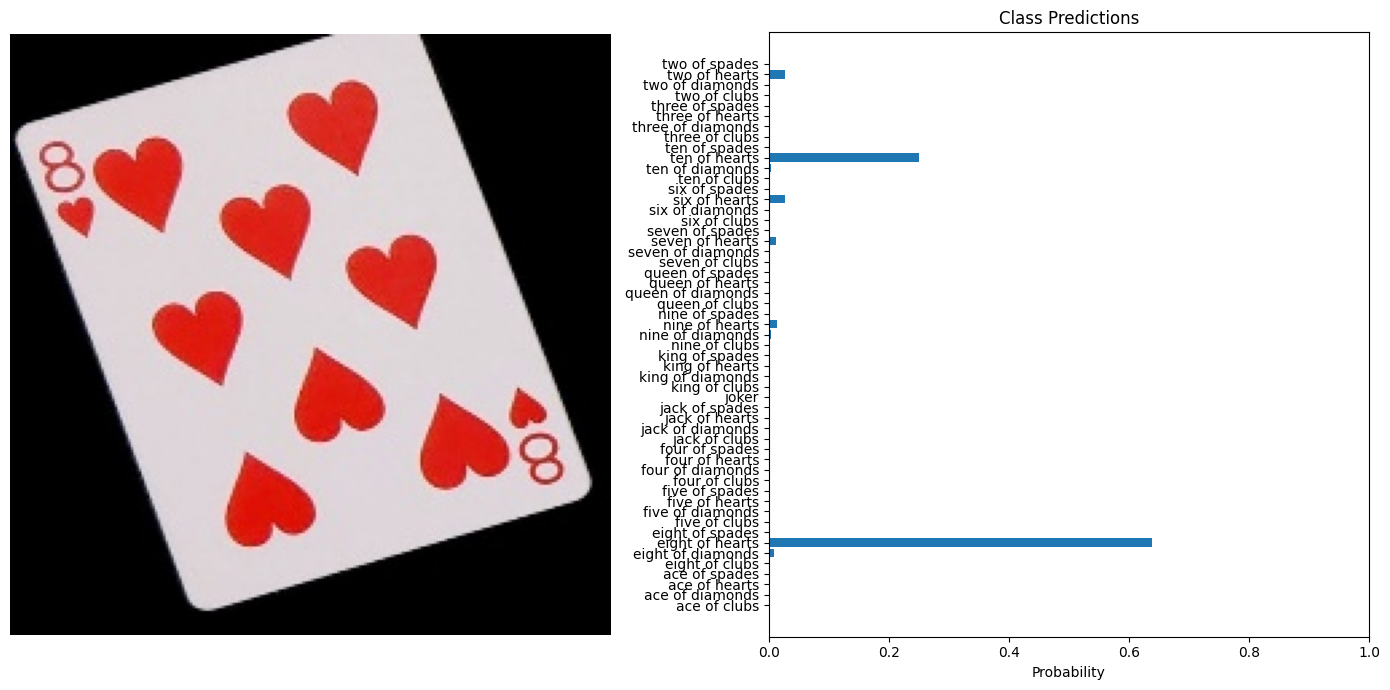

In [75]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

img_path = '/kaggle/input/cards-image-datasetclassification/test/eight of hearts/2.jpg'
image, tensor = pre_processing(img_path, transform)

p = predict(model, tensor, device)
class_names = train.classes
visualizer(image, p, class_names)